# load and convert to numbers

In [111]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import TargetEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
import shap
import matplotlib.pyplot as plt
from lib.preprocess import transform_problem, cyclic_encode
from lib.local_utils import show_confusionmatrix

In [112]:
SEED = 314
datasrc = "data/official/"
data = pd.read_csv(os.path.join(datasrc, "train.csv"), index_col=0)
x_test = pd.read_csv(os.path.join(datasrc, "test.csv"), index_col=0)

train, valid = train_test_split(data, test_size=0.2, random_state=42, stratify=data["health"])

In [113]:
x_train = train.drop("health", axis=1)
y_train = train["health"]
x_valid = valid.drop("health", axis=1)
y_valid = valid["health"]

In [114]:
steward_dict = {
    "None": 0,
    "1or2": 1,
    "3or4": 3,
    "4orMore": 4
} # nan is encoded as -10

curb_loc_dict = {
    "OnCurb": 1,
    "OffsetFromCurb": 0
}

guards_dict = {
    "Unsure": 0,
    "Helpful": 1,
    "Harmful": 2,
} # nan is encoded as -10

sidewalk_dict = {
    'Damage': 1,
    'NoDamage': 0
}

user_type_dict = {
    'Volunteer': 0,
    'NYC Parks Staff': 1,
    'TreesCount Staff': 2,
}

# convert from dict
# x_train["steward"] = x_train["steward"].apply(lambda x: steward_dict[x] if x in steward_dict else -10)
# x_valid["steward"] = x_valid["steward"].apply(lambda x: steward_dict[x] if x in steward_dict else -10)
# x_test["steward"] = x_test["steward"].apply(lambda x: steward_dict[x] if x in steward_dict else -10)

# x_train["curb_loc"] = x_train["curb_loc"].apply(lambda x: curb_loc_dict[x])
# x_valid["curb_loc"] = x_valid["curb_loc"].apply(lambda x: curb_loc_dict[x])
# x_test["curb_loc"] = x_test["curb_loc"].apply(lambda x: curb_loc_dict[x])

# x_train["guards"] = x_train["guards"].apply(lambda x: guards_dict[x] if x in guards_dict else -10)
# x_valid["guards"] = x_valid["guards"].apply(lambda x: guards_dict[x] if x in guards_dict else -10)
# x_test["guards"] = x_test["guards"].apply(lambda x: guards_dict[x] if x in guards_dict else -10)

# x_train["sidewalk"] = x_train["sidewalk"].apply(lambda x: sidewalk_dict[x])
# x_valid["sidewalk"] = x_valid["sidewalk"].apply(lambda x: sidewalk_dict[x])
# x_test["sidewalk"] = x_test["sidewalk"].apply(lambda x: sidewalk_dict[x])

# x_train["user_type"] = x_train["user_type"].apply(lambda x: user_type_dict[x])
# x_valid["user_type"] = x_valid["user_type"].apply(lambda x: user_type_dict[x])
# x_test["user_type"] = x_test["user_type"].apply(lambda x: user_type_dict[x])

In [115]:
x_train, problem_unique = transform_problem(x_train)
x_valid, _ = transform_problem(x_valid, problem_unique)
x_test, _ = transform_problem(x_test, problem_unique)

x_train = cyclic_encode(x_train)
x_valid = cyclic_encode(x_valid)
x_test = cyclic_encode(x_test)

In [116]:
ignore_columns = [
    "nta_name",
    "boro_ct",
    "spc_latin",
]
# get object columns
object_columns = [col for col in x_train.select_dtypes(include=["object"]).columns.tolist() if col not in ignore_columns]
object_columns

['curb_loc',
 'steward',
 'guards',
 'sidewalk',
 'user_type',
 'spc_common',
 'nta',
 'boroname',
 'zip_city']

In [117]:
preprocess = ColumnTransformer([
    ('cat',OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1),object_columns),
    # ('tar',TargetEncoder(target_type='binary',random_state=42),object_columns)
],remainder='passthrough')

x_train = pd.DataFrame(preprocess.fit_transform(x_train, y_train), columns=preprocess.get_feature_names_out(), index=x_train.index)
x_valid = pd.DataFrame(preprocess.transform(x_valid), columns=preprocess.get_feature_names_out(), index=x_valid.index)
x_test = pd.DataFrame(preprocess.transform(x_test), columns=preprocess.get_feature_names_out(), index=x_test.index)

In [118]:
x_train = x_train.fillna(-10)
x_valid = x_valid.fillna(-10)
x_test = x_test.fillna(-10)

In [119]:
dropcolumns = x_train.dtypes[x_train.dtypes == "object"].index.tolist()
x_train = x_train.drop(columns=dropcolumns)
x_valid = x_valid.drop(columns=dropcolumns)
x_test = x_test.drop(columns=dropcolumns)

# Implementation of SMOTE

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html

In [120]:
print(len(y_train))
print(y_train.value_counts())

15987
health
1    12601
0     2828
2      558
Name: count, dtype: int64


In [121]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(
    random_state=42,
    k_neighbors=5,
    n_jobs=-1,
    )
x_train, y_train = sm.fit_resample(x_train, y_train)

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.


discard data of 50%

In [122]:
# x_train, _, y_train, _ = train_test_split(x_train, y_train, test_size=0.5, random_state=SEED, stratify=y_train)

In [123]:
print(len(y_train))
print(y_train.value_counts())

37803
health
1    12601
0    12601
2    12601
Name: count, dtype: int64


In [124]:
def mean_f1score(preds:np.ndarray,eval_data: lgb.Dataset):
    y_true = eval_data.get_label()
    weight = eval_data.get_weight()
    preds = preds.reshape(len(np.unique(y_true)), -1)
    preds = preds.argmax(axis = 0)
    f1 = f1_score(y_true,preds,average='macro',sample_weight=weight)
    return 'f1',f1,True

In [125]:
model = lgb.LGBMClassifier(
    n_estimators = 1000,
    # learning_rate = 0.01,
    random_state = SEED,
    importance_type = "gain",
)
model.fit(
    x_train,
    y_train,
    # eval_set = [(x_valid, y_valid)],
    callbacks = [
        # lgb.reset_parameter(learning_rate=lambda x: 0.95 ** x * 0.01),
        ]
    )

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4628
[LightGBM] [Info] Number of data points in the train set: 37803, number of used features: 37
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


AttributeError: 'numpy.ndarray' object has no attribute 'get_label'

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

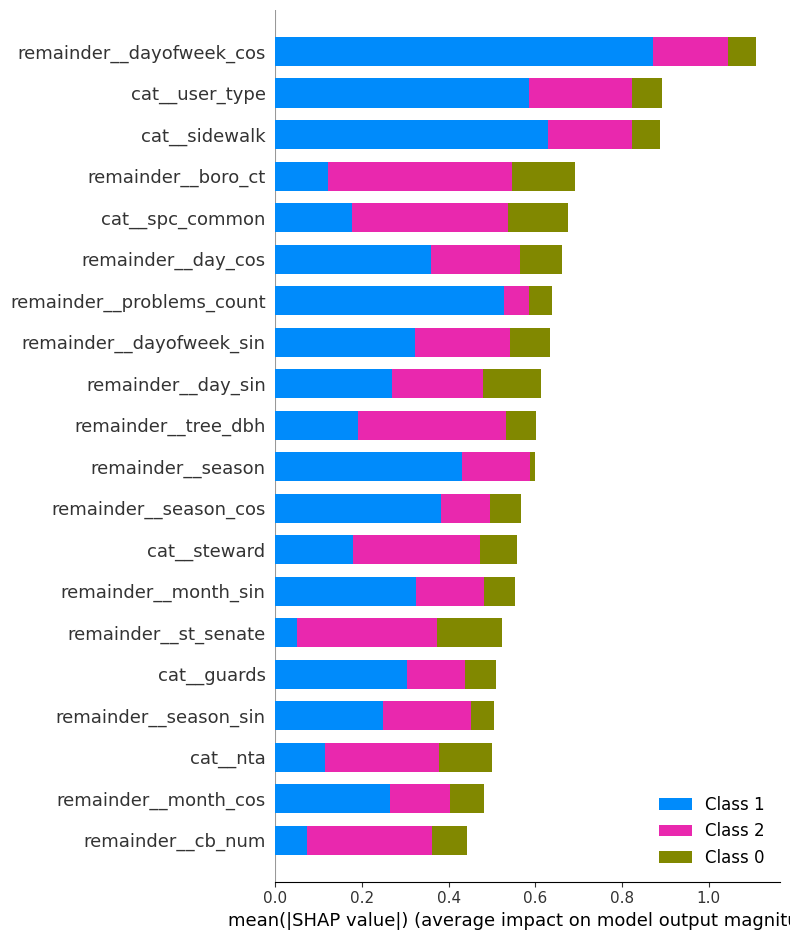

In [ ]:
shap.summary_plot(shap_values, x_valid, plot_type="bar")

ValueError: Could not find feature named: tree_dbh

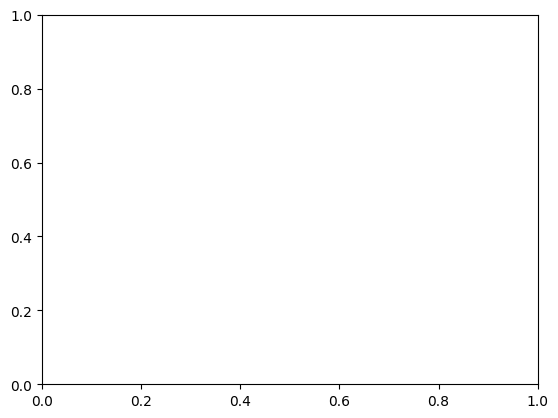

In [ ]:
feature_name = "tree_dbh"
color_list = ["tab:red", "tab:green", "tab:blue"]
fig, ax = plt.subplots()
for idx in range(3):
    shap.dependence_plot(feature_name, shap_values[idx], x_valid, interaction_index=None, ax=ax, color=color_list[idx], show=False, alpha=0.5)
ax.set_title(feature_name)
ax.set_xlabel(feature_name)
ax.set_ylabel("SHAP value")
ax.legend(["health: 0", "health: 1", "health: 2"])

In [ ]:
(train.loc[:,"health"].value_counts()/len(train)).values

array([0.78820291, 0.17689373, 0.03490336])

In [ ]:
def predict(model, x, thresholds=[0.3, 0.2, 0.05]):
    pred = model.predict_proba(x)
    pred = pd.DataFrame(pred, columns=["good", "normal", "bad"], index=x.index)
    pred["health"] = 1
    pred.loc[pred["good"] > thresholds[0], "health"] = 0
    pred.loc[pred["bad"] > thresholds[2], "health"] = 2
    return pred["health"]

def sort_predict(model, x, ratios=[0.176, 0.788, 0.035]):
    pred = model.predict_proba(x)
    pred = pd.DataFrame(pred, columns=["good", "normal", "bad"], index=x.index)
    good_count = int(len(x)*ratios[0])
    # normal_count = int(len(x)*ratios[1])
    bad_count = int(len(x)*ratios[2])
    pred_sortbybad = pred.sort_values(by="bad", ascending=False)
    # pred_sortbynormal = pred.sort_values(by="normal", ascending=False)
    pred_sortbygood = pred.sort_values(by="good", ascending=False)
    pred["health"] = 1
    pred.loc[pred_sortbybad.iloc[:bad_count, :].index, "health"] = 2
    pred.loc[pred_sortbygood.iloc[:good_count, :].index, "health"] = 0
    return pred["health"]

In [ ]:
pd.DataFrame(model.predict_proba(x_valid), columns=["good", "normal", "bad"]).describe().applymap("{:.2f}".format)

DataFrame.applymap has been deprecated. Use DataFrame.map instead.


,good,normal,bad
count,3997.00,3997.00,3997.00
mean,0.18,0.80,0.02
std,0.16,0.17,0.06
min,0.00,0.01,0.00
25%,0.06,0.73,0.00
50%,0.13,0.85,0.00
75%,0.24,0.92,0.02
max,0.99,1.00,0.83


In [ ]:
# max pred
pred_valid = pd.DataFrame(model.predict(x_valid), columns=["health"], index=x_valid.index)
f1_score(y_valid, pred_valid, average="macro")

0.3282607289981085

In [ ]:
# threshold pred
pred_threshold_valid = pd.DataFrame(predict(model, x_valid), columns=["health"], index=x_valid.index)
f1_score(y_valid, pred_threshold_valid, average="macro")

0.3420097595307315

In [ ]:
# sortby pred (I want to use for checking model correctly works. this approach is caused data leakage.)
pred_sortby_valid = pd.DataFrame(sort_predict(model, x_valid), columns=["health"], index=x_valid.index)
f1_score(y_valid, pred_sortby_valid, average="macro")

0.3384483520877028

In [ ]:
pred_sortby_valid.value_counts()/len(pred_sortby_valid)

health
1         0.793345
0         0.175882
2         0.030773
Name: count, dtype: float64

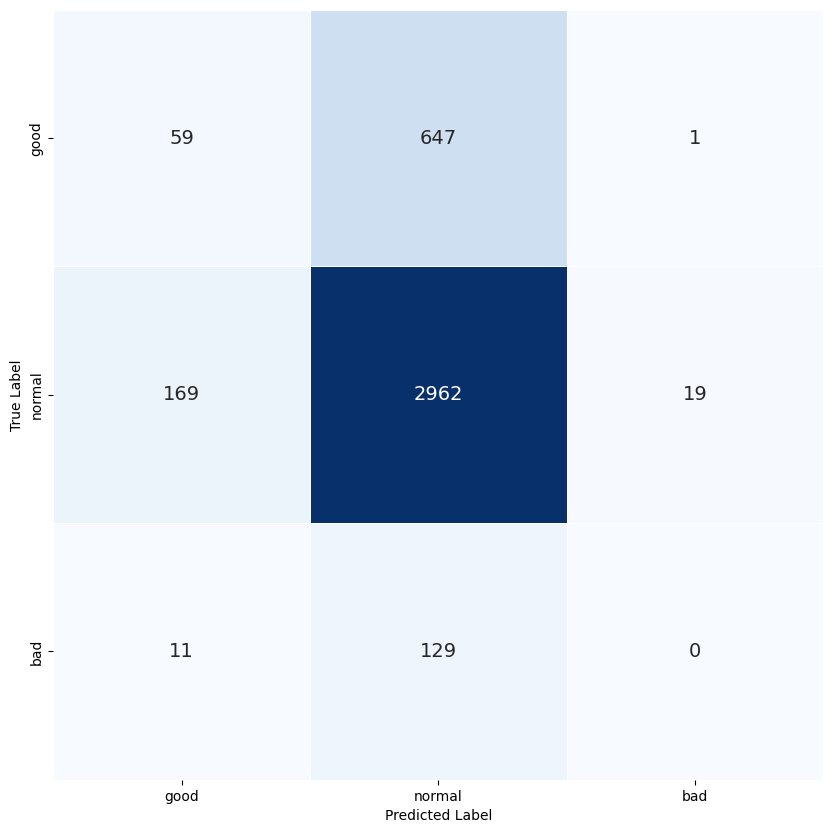

In [ ]:
show_confusionmatrix(y_valid, pred_valid, ["good", "normal", "bad"])

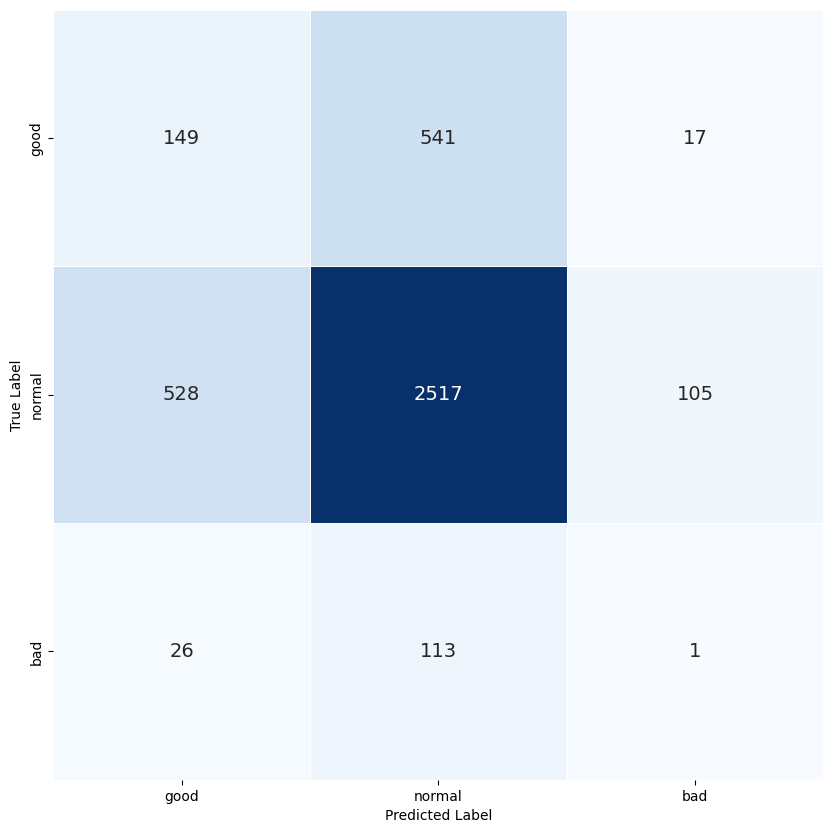

In [ ]:
show_confusionmatrix(y_valid, pred_sortby_valid, ["good", "normal", "bad"])

In [ ]:
pred_valid.value_counts()/len(pred_valid)

health
1         0.935201
0         0.059795
2         0.005004
Name: count, dtype: float64

In [ ]:
submit_name = "lgbm_smote"
predict = pd.DataFrame(predict(model, x_test), columns=["health"], index=x_test.index)
predict.to_csv(f"submission/{submit_name}_submission.csv",  header=False)
# model.booster_.save_model(f"model/{submit_name}_model.pt")